<a href="https://colab.research.google.com/github/l1f21bsee0018/DEEP-LEARNING/blob/main/OELL121F21BSEE0018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Kaggle API and upload kaggle.json for dataset access
!pip install -q kaggle
from google.colab import files
print("Upload your kaggle.json file")
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Upload your kaggle.json file


Saving kaggle.json to kaggle.json


In [ ]:
# Download and unzip the Chest X-Ray Images (Pneumonia) dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip -d /content/dataset

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:14<00:00, 202MB/s]
100% 2.29G/2.29G [00:14<00:00, 169MB/s]


In [ ]:
# Import necessary libraries and set parameters
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
SEED = 42

In [ ]:
# Define dataset directories
base_dir = '/content/dataset/chest_xray'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# The dataset's validation set is small, so we'll re-split train for better validation
# Move some images from train to val for a balanced split
import shutil
import random

os.makedirs(os.path.join(base_dir, 'new_val/NORMAL'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'new_val/PNEUMONIA'), exist_ok=True)

# Move 20% of train images to new_val
for category in ['NORMAL', 'PNEUMONIA']:
    train_cat_dir = os.path.join(train_dir, category)
    new_val_cat_dir = os.path.join(base_dir, 'new_val', category)
    images = os.listdir(train_cat_dir)
    random.seed(SEED)
    random.shuffle(images)
    num_val = int(0.2 * len(images))
    for img in images[:num_val]:
        shutil.move(os.path.join(train_cat_dir, img), os.path.join(new_val_cat_dir, img))

# Update validation directory
val_dir = os.path.join(base_dir, 'new_val')

In [ ]:
# Set up data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    seed=SEED
)

# Load validation data
validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    seed=SEED
)

# Load test data
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# Build the model using ResNet50V2
base_model = ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base model initially

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,089,601 (91.89 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
# Set up callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 113s 747ms/step - accuracy: 0.8144 - loss: 0.5042 - val_accuracy: 0.8389 - val_loss: 0.3602 - learning_rate: 0.0010
Epoch 2/20
  1/130 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - accuracy: 0.8750 - loss: 0.3093

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.8750 - loss: 0.3093 - val_accuracy: 0.8359 - val_loss: 0.3658 - learning_rate: 0.0010
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 89s 685ms/step - accuracy: 0.9208 - loss: 0.2008 - val_accuracy: 0.9209 - val_loss: 0.1914 - learning_rate: 0.0010
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.9688 - loss: 0.1604 - val_accuracy: 0.9219 - val_loss: 0.1880 - learning_rate: 0.0010
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9120 - loss: 0.2205 - val_accuracy: 0.9551 - val_loss: 0.1555 - learning_rate: 0.0010
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.9062 - loss: 0.1778 - val_accuracy: 0.9443 - val_loss: 0.1681 - learning_rate: 0.0010
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9214 - loss: 0.1973 - val_accuracy: 0.9395 - val_loss: 0.1677 - learning_rate: 0.0010
Epoch 8/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.8750 - loss: 0.2047 - 

In [ ]:
# Unfreeze some layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False  # Keep first 100 layers frozen

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Continue training
fine_tune_epochs = 10
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=fine_tune_epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 139s 820ms/step - accuracy: 0.9039 - loss: 0.2562 - val_accuracy: 0.9229 - val_loss: 0.1946 - learning_rate: 1.0000e-05
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.9062 - loss: 0.2304 - val_accuracy: 0.9248 - val_loss: 0.1913 - learning_rate: 1.0000e-05
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9345 - loss: 0.1647 - val_accuracy: 0.9570 - val_loss: 0.1258 - learning_rate: 1.0000e-05
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 1.0000 - loss: 0.0632 - val_accuracy: 0.9580 - val_loss: 0.1265 - learning_rate: 1.0000e-05
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 92s 706ms/step - accuracy: 0.9402 - loss: 0.1542 - val_accuracy: 0.9629 - val_loss: 0.1168 - learning_rate: 1.0000e-05
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.9688 - loss: 0.0612 - val_accuracy: 0.9629 - val_loss: 0.1184 - learning_rate: 1.0000e-05
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 142s 784ms/

In [ ]:
# Evaluate on training set
train_loss, train_accuracy = model.evaluate(train_generator)
print(f"Training Accuracy: {train_accuracy*100:.2f}%")

# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

131/131 ━━━━━━━━━━━━━━━━━━━━ 81s 616ms/step - accuracy: 0.9736 - loss: 0.0882
Training Accuracy: 96.55%
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 429ms/step - accuracy: 0.9663 - loss: 0.1198
Validation Accuracy: 96.36%
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 543ms/step - accuracy: 0.8892 - loss: 0.3545
Test Accuracy: 92.15%


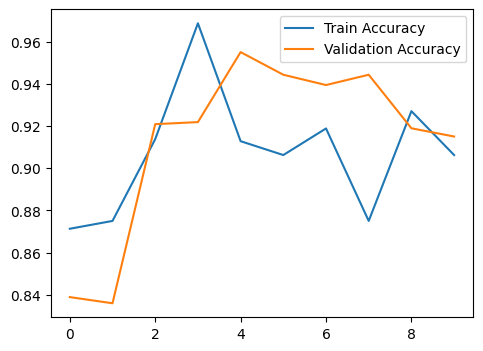

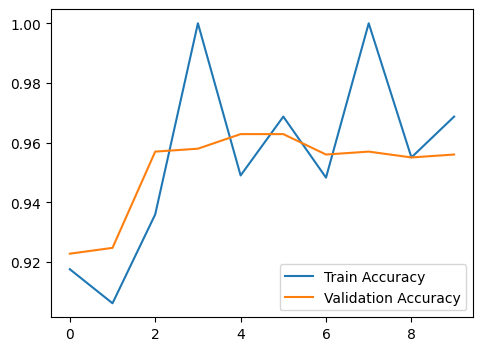

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


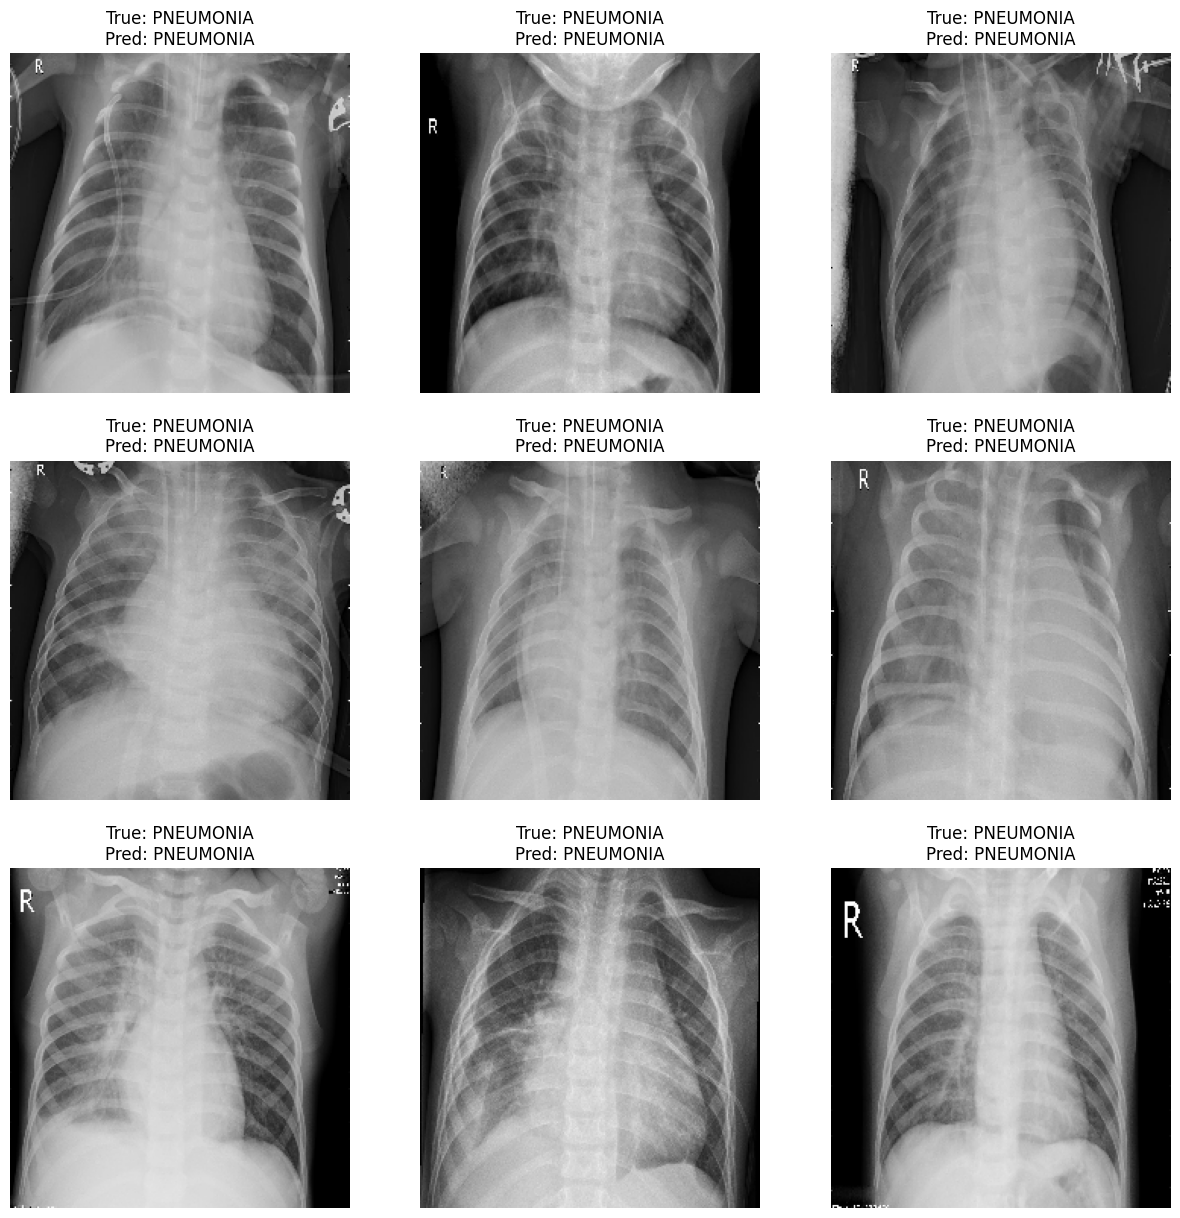

In [ ]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()



    plt.legend()

    plt.show()

plot_history(history)
if 'history_fine' in locals():
    plot_history(history_fine)

class_names = sorted(test_generator.class_indices.keys())

# Display some predictions
plt.figure(figsize=(15, 15))
# Use iter() to create an iterator from the generator
test_iter = iter(test_generator)
for i in range(9):
    plt.subplot(3, 3, i+1)
    # Use next() to get the next batch
    img, label = next(test_iter)
    # Since we're getting a batch, predict on the first image in the batch
    # The model's output is a single value between 0 and 1 for binary classification.
    # We round the output to get the predicted class index (0 or 1).
    pred_index = round(model.predict(img[0:1])[0][0])
    pred_label = class_names[pred_index]

    # The label is a numpy array for the batch, so get the true label for the first image
    # For binary classification with class_mode='binary', the label is a single value (0 or 1).
    true_index = int(label[0])
    true_label = class_names[true_index]

    plt.imshow(img[0])
    plt.title(f'True: {true_label}\nPred: {pred_label}')
    plt.axis('off')
plt.show()